In [1]:
import ee
import pandas as pd
import numpy as np
import plotnine
from plotnine import *

import sys
from tqdm.auto import tqdm

from dfply import *

In [2]:
# authenticate earthengine api
ee.Initialize()

In [3]:
# append sys_path, and import custom moduls
sys.path.append('./')
sys.path.append('../Step_1_UNET_predict_future_urbanization/torch_modules')


# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# get the pixel size for exporting img later
one_GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical")
GAEZ_pix_scale = one_GAEZ_img.projection().nominalScale().getInfo()

# the NCP image mask
NCP_img_mask = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992").first().mask()
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

In [6]:
# function to compute the area ratio of each crop given the irrigated/rainfed water supply
def compute_crop_water_ratio(in_path,crop):

  in_dfs = actual_area >> mask(X.crop==crop)
  area_ratio = ee.Image(in_path).divide(cropland_area_sum)

  return ee.Image(area_ratio)

In [7]:
# # import GAEZ data from ee_asset
# GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# # actual harvested area
# actual_area = get_img_df(img_path = GAEZ_list,
#               theme = 'GAEZ_5',
#               variable = ['Harvested_area'],
#               time = '2010',
#               crop = ['Maize','Wetland_rice','Wheat'],
#               water = ['Rainfed','Irrigated'])

# # get the total cropland area
# cropland_area_sum = ee.ImageCollection([ee.Image(i) for i in actual_area['GEE_path'].tolist()]).sum()

# # get the area ratio
# actual_area['area_ratio'] = actual_area.apply(lambda row:compute_crop_water_ratio(row['GEE_path'],row['crop']),1 )

# # save GAEZ_2010_cropland to disk
# actual_area.to_pickle('./result_csv/actual_area.pkl')

actual_area = pd.read_pickle('./result_csv/actual_area.pkl')

In [8]:
# get yearbook cropland area
yearbook_path = '../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield'
crop_dict = {'maize':'Maize','wheat':'Wheat','rice':'Wetland_rice'}

# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

# # loop through each crop
# out_dfs = []
# for k,v in crop_dict.items():
#   df = pd.read_csv(f'{yearbook_path}/Area_{k}.csv')
#   df = df.set_index('Zone').stack().reset_index()
#   df.columns = ['Province','year','area_yearbook_kha']

#   df['year'] = df['year'].astype(int)
#   df['crop'] = v
#   out_dfs.append(df)

# # get the records in the NCP
# yearbook_area = pd.concat(out_dfs).reset_index(drop=True).replace(city_cn_en) >> mask(X.Province.isin(city_cn_en.values()))

# # save yearbook_cropland_area to disk
# yearbook_area.to_csv('./result_csv/yearbook_area.csv',index=False)

# read yearbook cropland area
yearbook_area = pd.read_csv('./result_csv/yearbook_area.csv')
yearbook_area_2020 = yearbook_area.query('year==2020') >> drop(X.year) >> rename(area_yearbook_kha_2020=X.area_yearbook_kha)

### 1) compute the ratio of yearbook_cropland/GAEZ_cropland

In [9]:
# get the GEAZ_2010 cropland area
actual_area_2010_stats = []


for idx,row in tqdm(actual_area.iterrows(),total=len(actual_area)):
  crop = row['crop']
  water = row['water']
  cropland_img = ee.Image(row['GEE_path'])
  cropland_img = cropland_img.updateMask(cropland_img.gt(0))

  stats = ee.Image(cropland_img).reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()

  stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] 
                           for i in stats['features']}).T.reset_index()
  stats_df.columns = ['Province','GAEZ_area_2010_kha']
  stats_df['crop'] = crop
  stats_df['water'] = water
  stats_df['year'] = 2010
  

  actual_area_2010_stats.append(stats_df)

# merge dfs
actual_area_2010_df = pd.concat(actual_area_2010_stats).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
# compute the difference between GAEZ_cropland and yearbook_cropland area
actual_area_2010_df_crop_sum = actual_area_2010_df.groupby(['Province','crop','year']).sum(numeric_only=True).reset_index()
actual_area_2010_df_crop_sum = actual_area_2010_df_crop_sum >> rename(GAEZ_area_2010_kha_sum = 'GAEZ_area_2010_kha')

# compute the difference
cropland_area_diff = actual_area_2010_df_crop_sum.merge(yearbook_area_2020)
cropland_area_diff['delta'] = cropland_area_diff['area_yearbook_kha_2020'] - cropland_area_diff['GAEZ_area_2010_kha_sum']

cropland_area_diff.head()

,Province,crop,year,GAEZ_area_2010_kha_sum,area_yearbook_kha_2020,delta
0,Anhui,Maize,2010,652.328186,1234.76,582.431814
1,Anhui,Wetland_rice,2010,3033.257141,2512.08,-521.177141
2,Anhui,Wheat,2010,1653.712613,2825.20,1171.487387
3,Beijing,Maize,2010,315.041405,35.65,-279.391405
4,Beijing,Wetland_rice,2010,16.711141,0.20,-16.511141


In [11]:
cropland_area_diff_for_plot = (cropland_area_diff >> drop(['delta'])).set_index(['Province','crop','year']).stack().reset_index()
cropland_area_diff_for_plot = cropland_area_diff_for_plot.rename({'level_3':'source',0:'area'},axis='columns')

cropland_area_diff_for_plot.head()

,Province,crop,year,source,area
0,Anhui,Maize,2010,GAEZ_area_2010_kha_sum,652.328186
1,Anhui,Maize,2010,area_yearbook_kha_2020,1234.760000
2,Anhui,Wetland_rice,2010,GAEZ_area_2010_kha_sum,3033.257141
3,Anhui,Wetland_rice,2010,area_yearbook_kha_2020,2512.080000
4,Anhui,Wheat,2010,GAEZ_area_2010_kha_sum,1653.712613


In [12]:
# organize for plotting
cropland_area_diff_for_plot = (cropland_area_diff >> drop(['delta'])).set_index(['Province','crop','year']).stack().reset_index()
cropland_area_diff_for_plot = cropland_area_diff_for_plot.rename({'level_3':'source',0:'area'},axis='columns')

cropland_area_diff_for_plot_strip = cropland_area_diff_for_plot.copy()
cropland_area_diff_for_plot_strip.loc[cropland_area_diff_for_plot_strip['source']=='GAEZ_area_2010_kha_sum','area'] = 0

c:\conda\envs\gee\Lib\site-packages\plotnine\scales\scale_alpha.py:73: PlotnineWarning: Using alpha for a discrete variable is not advised.
c:\conda\envs\gee\Lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


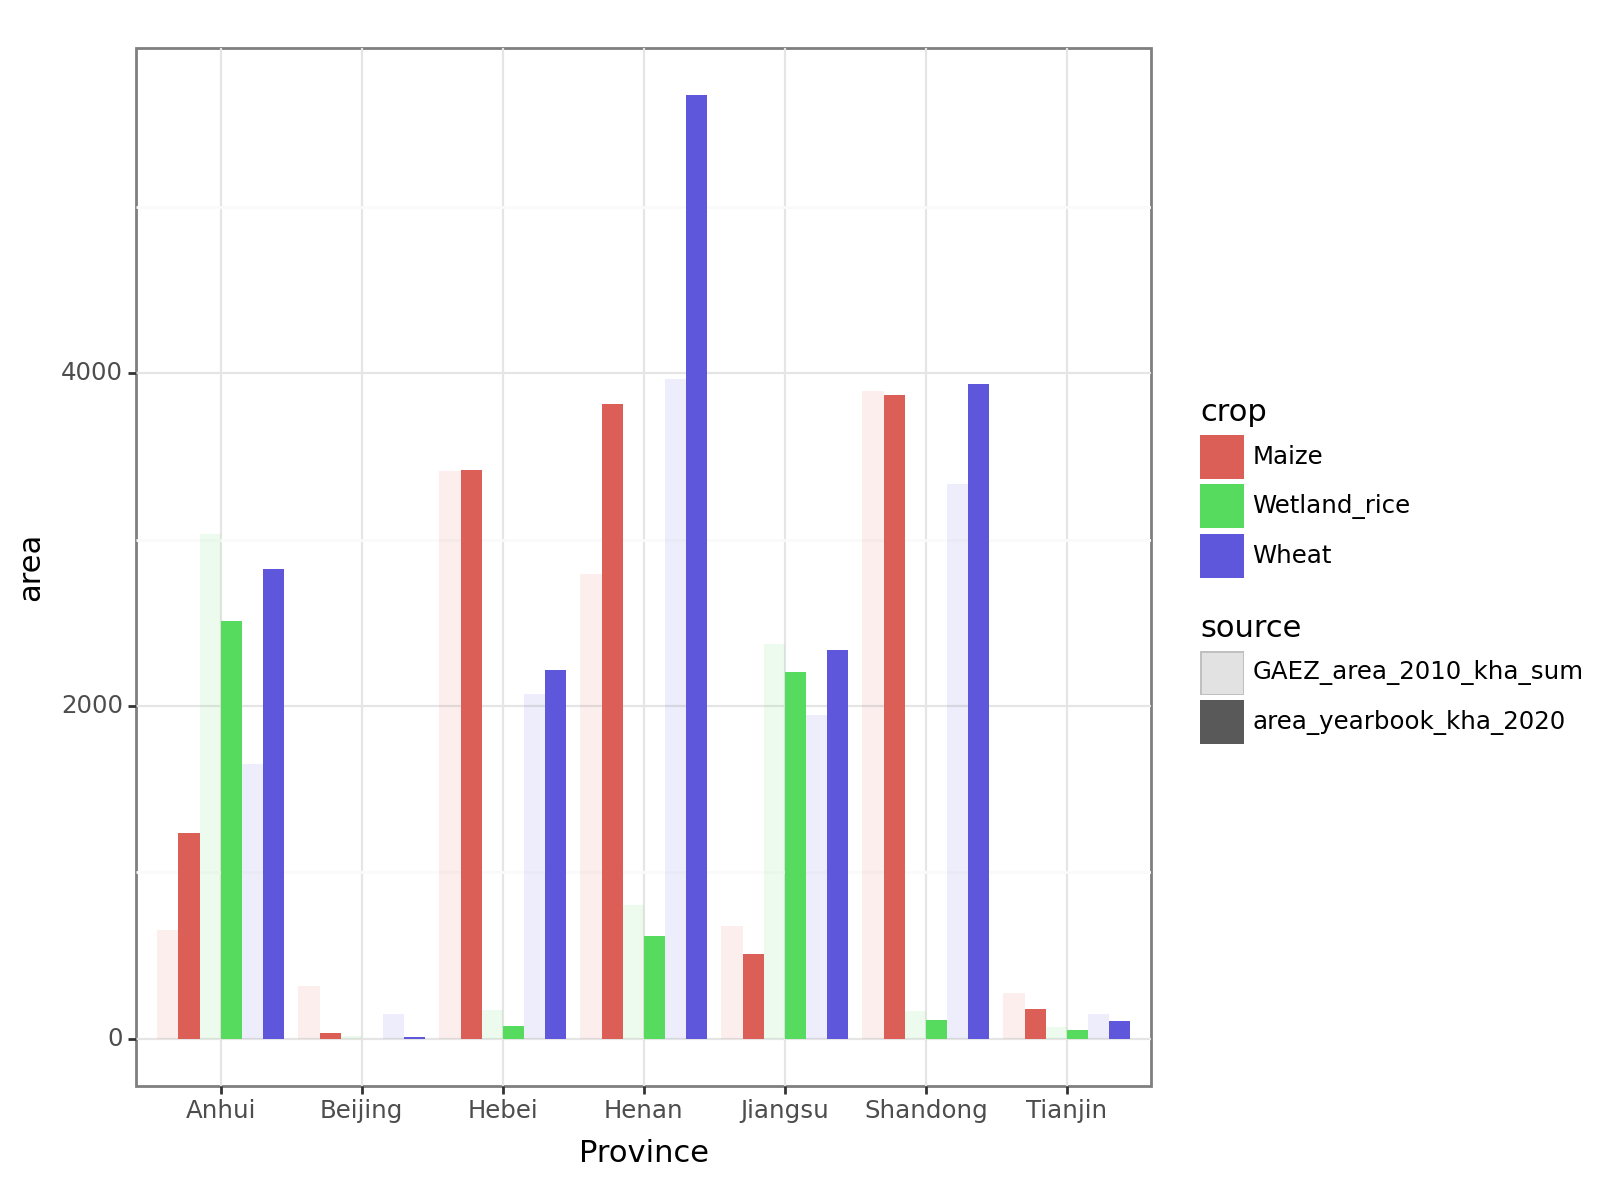

<Figure Size: (800 x 600)>

In [17]:
# plot the area change
plotnine.options.figure_size = (8,6)
plotnine.options.dip = 100

# has to make this figure via R, beccause fill_patter is not avaliable
(ggplot(cropland_area_diff_for_plot)
 + geom_col(aes(x='Province',y='area',fill='crop',alpha='source'),position='dodge')
 + scale_color_manual(values={'GAEZ_area_2010_kha_sum':'white','area_yearbook_kha':'grey'})
 + theme_bw()
 )

- Use R to make the plot because the package of "ggpattern" is not alaliable for Python <br>
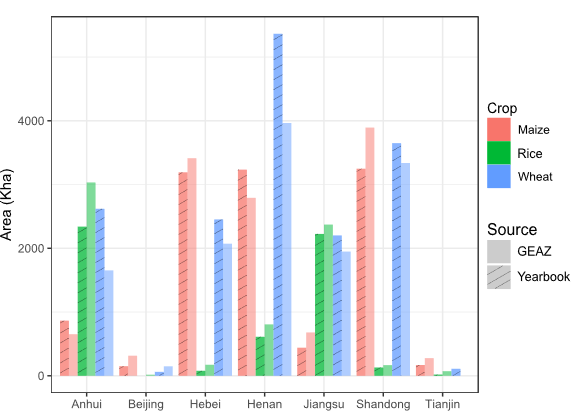

In [18]:
actual_area_2010_df_with_ratio = cropland_area_diff.copy()
actual_area_2010_df_with_ratio['delta_ratio'] = actual_area_2010_df_with_ratio['area_yearbook_kha_2020'] / actual_area_2010_df_with_ratio['GAEZ_area_2010_kha_sum']
actual_area_2010_df_with_ratio.head()

,Province,crop,year,GAEZ_area_2010_kha_sum,area_yearbook_kha_2020,delta,delta_ratio
0,Anhui,Maize,2010,652.328186,1234.76,582.431814,1.892851
1,Anhui,Wetland_rice,2010,3033.257141,2512.08,-521.177141,0.828179
2,Anhui,Wheat,2010,1653.712613,2825.20,1171.487387,1.708398
3,Beijing,Maize,2010,315.041405,35.65,-279.391405,0.113160
4,Beijing,Wetland_rice,2010,16.711141,0.20,-16.511141,0.011968


### 2) clip the GAEZ_cropland with NCP_shp, then multiply the clipped img with delta_ratio

In [19]:
# get ee.shp boundary for each province
province_shp = {n:[ee.Feature(NCP_shp.filter(ee.Filter.eq('EN_Name',n)).first())] for n in  list(city_cn_en.values())}
province_shp_df = pd.DataFrame(province_shp).T.reset_index()
province_shp_df.columns = ['Province','shp']

In [20]:
# link GAEZ_2010_cropland with province_shp
actual_area_with_province_shp = actual_area.copy()
actual_area_with_province_shp['Province'] = [province_shp_df['Province'].tolist()] * len(actual_area_with_province_shp)
actual_area_with_province_shp['shp'] = [province_shp_df['shp'].tolist()] * len(actual_area_with_province_shp)
actual_area_with_province_shp = actual_area_with_province_shp.explode(['Province','shp']).reset_index(drop=True)

# link the delta_ratio with province
actual_area_with_delta_ratio = actual_area_with_province_shp.merge(actual_area_2010_df_with_ratio)
actual_area_with_delta_ratio = actual_area_with_delta_ratio >> select(['Province','crop','water','year','GEE_path','shp','delta_ratio'])

actual_area_with_delta_ratio.head()

,Province,crop,water,year,GEE_path,shp,delta_ratio
0,Beijing,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",0.113160
1,Tianjin,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",0.645695
2,Hebei,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",1.001161
3,Jiangsu,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",0.750136
4,Anhui,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",1.892851


In [21]:
# multiply the delta_ratio, then mosaic the imgs of different province to a single img
def multiply_ratio(row):
  in_img = ee.Image(row['GEE_path']).clip(row['shp']).multiply(row['delta_ratio'])
  return in_img

# apply the function
actual_area_with_delta_ratio['GAEZ_2020_cropland_corrcted'] = actual_area_with_delta_ratio.apply(lambda row:multiply_ratio(row),1)

# change name and save to disk
GAEZ_cropland_2020_corrected = actual_area_with_delta_ratio.copy() \
              >> select(['Province','crop','water','GAEZ_2020_cropland_corrcted'])

GAEZ_cropland_2020_corrected = GAEZ_cropland_2020_corrected.groupby(['crop','water'])\
                  .apply(lambda df:ee.ImageCollection(df['GAEZ_2020_cropland_corrcted'].tolist()).mosaic())\
                  .reset_index()

# rename cols and save to disk
GAEZ_cropland_2020_corrected.columns = ['crop','water','GAEZ_2020_cropland_corrcted']


# merge with the actual_area (raw GAEZ_2010_cropland) for compatibility
GAEZ_cropland_2020_corrected = GAEZ_cropland_2020_corrected.merge(actual_area)
GAEZ_cropland_2020_corrected.to_pickle('./result_csv/GAEZ_cropland_2020_corrected.pkl')

GAEZ_cropland_2020_corrected

C:\Users\Jinzhu WANG\AppData\Local\Temp\ipykernel_16668\2167254166.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,crop,water,GAEZ_2020_cropland_corrcted,theme,variable,time,GEE_path,area_ratio
0,Maize,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Maize,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Wetland_rice,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Wetland_rice,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Wheat,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
5,Wheat,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."


### 3) validate the corrected GAEZ_2020_cropland has the same area as the yearbook records

In [22]:
# get the GEAZ_2010 cropland area
actual_area_2020_stats_corrected = []


for idx,row in tqdm(GAEZ_cropland_2020_corrected.iterrows(),total=len(GAEZ_cropland_2020_corrected)):
  crop = row['crop']
  water = row['water']
  cropland_img = row['GAEZ_2020_cropland_corrcted']

  stats = ee.Image(cropland_img).reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()

  stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] 
                           for i in stats['features']}).T.reset_index()
  
  stats_df.columns = ['Province','GAEZ_area_2020_kha']
  stats_df['crop'] = crop
  stats_df['water'] = water
  stats_df['year'] = 2020
  

  actual_area_2020_stats_corrected.append(stats_df)

# merge dfs
actual_area_2020_corrected_df = pd.concat(actual_area_2020_stats_corrected).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
# compute the difference between GAEZ_cropland_corrected and yearbook_cropland area
actual_area_2020_df_crop_sum_corrected = actual_area_2020_corrected_df.groupby(['Province','crop','year']).sum().reset_index()
cropland_area_diff_corrected = actual_area_2020_df_crop_sum_corrected.merge(yearbook_area)

cropland_area_diff_corrected['ratio'] = cropland_area_diff_corrected['GAEZ_area_2020_kha'] \
                      / cropland_area_diff_corrected['area_yearbook_kha']

cropland_area_diff_corrected['delta'] = cropland_area_diff_corrected['GAEZ_area_2020_kha'] \
                      - cropland_area_diff_corrected['area_yearbook_kha']

cropland_area_diff_corrected

,Province,crop,year,GAEZ_area_2020_kha,water,area_yearbook_kha,ratio,delta
0,Anhui,Maize,2020,1219.083206,IrrigatedRainfed,1234.76,0.987304,-15.676794
1,Anhui,Wetland_rice,2020,2513.258078,IrrigatedRainfed,2512.08,1.000469,1.178078
2,Anhui,Wheat,2020,2810.605458,IrrigatedRainfed,2825.20,0.994834,-14.594542
3,Beijing,Maize,2020,55.537874,IrrigatedRainfed,35.65,1.557865,19.887874
4,Beijing,Wetland_rice,2020,0.747159,IrrigatedRainfed,0.20,3.735793,0.547159
5,Beijing,Wheat,2020,19.528755,IrrigatedRainfed,8.39,2.327623,11.138755
6,Hebei,Maize,2020,3407.528511,IrrigatedRainfed,3417.10,0.997199,-9.571489
7,Hebei,Wetland_rice,2020,79.051140,IrrigatedRainfed,78.72,1.004207,0.331140
8,Hebei,Wheat,2020,2215.140556,IrrigatedRainfed,2216.92,0.999197,-1.779444
9,Henan,Maize,2020,3813.523422,IrrigatedRainfed,3818.01,0.998825,-4.486578
